<a href="https://colab.research.google.com/github/kniemi641/UC-MScA/blob/master/Homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2

The purpose of this exercise is to use the gradient descent to solve for the best model parameters for a multivariate linear regression. This is a continuation of the Homework 1, inorder to prove that gradient descent can be used to *fit* for the optimum parameters of any model with a cost function. In this case we are proving it can be used to solve for the analytical solution for a linear regression.

Since this a continuation, I will give a brief overview of the explatory analysis which was already performed :

* Data is imported, observations containing null values in either the predictor or response variables are excluded.

* There are outlier observations with STheta values ~10x larger than the mean. These have been removed. 
* A ones column is appended to the predictor set to solve for the intercept parameter


### Packages & Variables



In [0]:
# Generic packages
import pandas as pd
import numpy as np
import math
import os
from scipy import stats

# sklearn model packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# plotting packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import seaborn as sns
%matplotlib inline

# utility stuff
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive, files
drive.mount('/content/gdrive')

np.random.seed(235)

In [0]:
#GLOBAL & CONSTANTS

# dynamic
NUM = 2
INPUT_DATA_FILE = 'bottle.csv'

# static
GD_CODE_DIR = '/content/gdrive/My Drive/Code/uchicago/'
SUBJECT_DIR = 'Machine Learning & Predictive Analytics/'
DATA_DIR = 'data/'
MODEL_DIR = 'models/'
LOGS_DIR = 'logs/'
HOMEWORK_DIR = 'Homework {}/'.format(NUM)
NOTEBOOK_NAME = 'Homework {}.ipynb'.format(NUM)


MAIN_PATH = os.path.join(GD_CODE_DIR
                        ,SUBJECT_DIR
                        ,HOMEWORK_DIR)

INPUT_FILE = os.path.join(MAIN_PATH
                          ,DATA_DIR
                          ,INPUT_DATA_FILE)

NOTEBOOK_FILE = os.path.join(MAIN_PATH
                            ,NOTEBOOK_NAME)

MODEL_EXPORT_PATH = os.path.join(MAIN_PATH
                                ,MODEL_DIR)

LOG_PATH = os.path.join(MAIN_PATH
                       ,LOGS_DIR)

## Exploratory Analysis

See Homework 1

In [4]:
#Load data and take a look at it
water_data = pd.read_csv(INPUT_FILE)
water_df = pd.DataFrame(water_data)

water_data.head(5)
print(water_df.describe())
print('\n Columns from input file: \n {}'.format(water_data.columns))

             Cst_Cnt        Btl_Cnt         Depthm         T_degC  \
count  864863.000000  864863.000000  864863.000000  853900.000000   
mean    17138.790958  432432.000000     226.831951      10.799677   
std     10240.949817  249664.587269     316.050259       4.243825   
min         1.000000       1.000000       0.000000       1.440000   
25%      8269.000000  216216.500000      46.000000       7.680000   
50%     16848.000000  432432.000000     125.000000      10.060000   
75%     26557.000000  648647.500000     300.000000      13.880000   
max     34404.000000  864863.000000    5351.000000      31.140000   

              Salnty         O2ml_L         STheta          O2Sat  \
count  817509.000000  696201.000000  812174.000000  661274.000000   
mean       33.840350       3.392468      25.819394      57.103779   
std         0.461843       2.073256       1.167787      37.094137   
min        28.431000      -0.010000      20.934000      -0.100000   
25%        33.488000       1.3600

In [5]:
# From Homework 1, remove outliers and NAs
water_df_clean = water_df[water_df.Salnty.notnull() 
                          & water_df.STheta.notnull() 
                          & water_df.T_degC.notnull()]

predictors = ['Salnty', 'STheta']
response = ['T_degC']

print(water_df_clean.describe())

             Cst_Cnt        Btl_Cnt         Depthm         T_degC  \
count  812174.000000  812174.000000  812174.000000  812174.000000   
mean    17730.743314  446791.897298     222.434704      10.847904   
std     10079.691018  245798.556428     308.778427       4.221005   
min         1.000000       1.000000       0.000000       1.440000   
25%      9209.000000  240468.250000      47.000000       7.750000   
50%     17873.000000  451139.500000     125.000000      10.100000   
75%     26984.000000  659663.750000     300.000000      13.910000   
max     34404.000000  864863.000000    5351.000000      31.140000   

              Salnty         O2ml_L         STheta          O2Sat  \
count  812174.000000  661268.000000  812174.000000  661270.000000   
mean       33.842424       3.416076      25.819394      57.103825   
std         0.461567       2.068615       1.167787      37.094054   
min        28.431000      -0.010000      20.934000      -0.100000   
25%        33.490000       1.4000

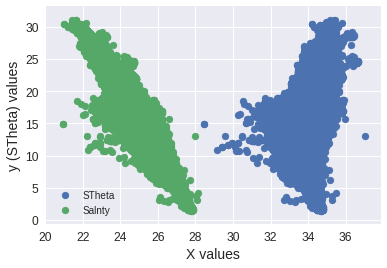


 Shape of y:   (812168,)

 Shape of X:   (812168, 2)


In [7]:
X_df = water_df_clean[predictors]
y_df = water_df_clean[response]

stheta_cut_off = 100

# from HW 1 we know there are some STheta outliers
y = y_df[X_df['STheta'].values < stheta_cut_off].values.ravel()
X = X_df[X_df['STheta'].values < stheta_cut_off].values

plt.scatter(X[:,0],y,label='STheta')  
plt.scatter(X[:,1],y,label='Salnty')  
plt.grid(True)
plt.legend()
plt.xlabel('X values')
plt.ylabel('y (STheta) values')
plt.show()


print('\n Shape of y:   {}'.format(y.shape))
print('\n Shape of X:   {}'.format(X.shape))

## Train and Test Data

In order to test the performance of the model generated by the gradient descent, the data are split into a train and test set. The sklearn function, `train_test_split` is used, splits an input dataset randomly (with seed functionality) into a provided ratio.

The predictors are also scaled using the sklearn Standard Scaler. This will  center the data around 0 and normalize the data to a standard deviation of 1. This is to help during the gradient descent. If the $X$' scales are wildly different, a small adjustment in one to determine the optimum gradient path may drastically overpower a small adjustment in the other. **The test set is scaled using the parameters from the training set, to avoid data leakage** When validating model fit, it is important to keep the validation / test set isolated so the model can not gain any additional information from the test set. 



In [13]:
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size , random_state = 239)

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

X_train_scale= np.column_stack([X_train_scale, np.ones([X_train_scale.shape[0], 1], dtype=np.int32)])
X_test_scale = np.column_stack([X_test_scale, np.ones([X_test_scale.shape[0], 1], dtype=np.int32)])

print("Training Data: {} of original dataset".format(1-test_size)) 
print("y Data Shape: {}".format(y_train.shape)) 
print("X Data Shape: {}".format(X_train_scale.shape)) 
print("Scaled X Data:\n {}".format(pd.DataFrame(X_train_scale).describe())) 

print("\n\nTest Data: {} of original dataset".format(test_size))
print("y Data Shape: {}".format(y_test.shape))
print("X Data Shape: {}".format(X_test_scale.shape))
print("Scaled X Data: \n {}".format(pd.DataFrame(X_test_scale).describe()))

Training Data: 0.7 of original dataset
y Data Shape: (568517,)
X Data Shape: (568517, 3)
Scaled X Data:
                   0             1         2
count  5.685170e+05  5.685170e+05  568517.0
mean   2.357253e-12  3.443218e-13       1.0
std    1.000001e+00  1.000001e+00       0.0
min   -1.171888e+01 -4.849723e+00       1.0
25%   -7.638039e-01 -8.466356e-01       1.0
50%    5.907173e-02  1.769714e-01       1.0
75%    7.715088e-01  8.223104e-01       1.0
max    6.910594e+00  2.303612e+00       1.0


Test Data: 0.3 of original dataset
y Data Shape: (243651,)
X Data Shape: (243651, 3)
Scaled X Data: 
                    0              1         2
count  243651.000000  243651.000000  243651.0
mean       -0.002104      -0.003176       1.0
std         0.998328       1.000283       0.0
min       -11.718877      -4.849723       1.0
25%        -0.763804      -0.848621       1.0
50%         0.054741       0.174986       1.0
75%         0.765012       0.819332       1.0
max         6.037913       

Now both the predictors in train set are centered around 0 with a standard deviation of 1. The test set is centered around *nearly* one with a standard deviation of *nearly* 1. This is to be expected as the data was **randomly split** into the train and test set.

## Minibatch Gradient Descent

Next gradient descent is performed to find the model parameters, theta, which minimize the cost function. A mini-batch method was chosen to minimize computation time. The function uses a learning rate $eta$, and performs gradient descent over a set of predictors and response variables for a provided $epoch$ count. 

The parameters, theta, are then used to solve for the model predictions, yhat, which can then yield RMSE, R-squared and variance explained.

In [0]:
def grad_desc_minibatch_model(predictors, response, minibatch_sizes, eta = 0.1, epochs = 100):  
    # minibatch size
    # eta - learning rate
    # epochs - number of epochs to run
    m = len(predictors)
        
    thetas_final = []
    
    #for each batchsize in the batchize vector
    for i, batch_size in enumerate(minibatch_sizes):
      print('\n Execution gradient descent {} using minibatch size of {} \n'.format(i+1, minibatch_sizes[i]))
      
      #initialize random theta
      theta = np.random.randn(3,1)
      
      #iterate over each epoch
      for iteration in range(epochs):    
          
          #get random subsamples of length m
          shuffled_indices = np.random.permutation(m)
          X_b_shuffled = predictors[shuffled_indices]
          y_shuffled = response[shuffled_indices]
          
          for i in range(0, m, batch_size):
              
              # set of shuffled Xs,Yx=s
              xi = X_b_shuffled[i:i+batch_size]
              yi = y_shuffled[i:i+batch_size]
              
              #determine gradient using blank equation
              gradients = 2/batch_size * xi.T.dot(xi.dot(theta) - np.asmatrix(yi).T)
              
              #update theta by using the gradient vector and scaler learning rate
              theta = theta - eta * gradients
      
      thetas_final.append(theta)

    print('Finished!')
    return thetas_final


In [15]:
minibatchs = [50,2000,10000] 
model_thetas_list = grad_desc_minibatch_model(X_train_scale, y_train, minibatchs) 


 Execution gradient descent 1 using minibatch size of 50 


 Execution gradient descent 2 using minibatch size of 2000 


 Execution gradient descent 3 using minibatch size of 10000 

Finished!


In [17]:
def summarize_coeffs(list, col_names, index_values, header='Values'):  
  for i, item in enumerate(list):
    print('\n{} : {}'.format(header, minibatchs[i]))
    df = pd.DataFrame(item).round(3)
    df.columns = col_names
    df.rename(index=index_values, inplace=True)
    print(df,'\n')
  return
 
column_names = ['Coefficients']
index_values = {0:'Salnty',1:'STheta', 2:'Intercept'}

summarize_coeffs(model_thetas_list, column_names, index_values, 'MiniBatch Sizes')


MiniBatch Sizes : 50
           Coefficients
Salnty            1.513
STheta           -5.114
Intercept        10.835 


MiniBatch Sizes : 2000
           Coefficients
Salnty            1.431
STheta           -5.060
Intercept        10.848 


MiniBatch Sizes : 10000
           Coefficients
Salnty            1.432
STheta           -5.074
Intercept        10.843 



The model parameters from our gradient descent look very different from those found using the standard linear regression model. However, this is due to the fact we have trained our model (found the best fit parameters) using **scaled** data. We can evalue the performance of the model by comparing the scoring metrics from the first model. Below are functions to get the model metrics of interest.

## Model Fit

In [0]:
def get_model_stats(model_params, X, y):
  
  yhat = np.dot(X, model_params).T
  residuals = np.square(np.subtract(yhat, y))
  SSE = np.sum(residuals)
  ybar = np.repeat(np.average(y), len(y))
  SST = np.sum(np.square(np.subtract(ybar, y)))   
  RMSE = np.sqrt(np.sum(np.square(yhat - y)) / len(y))
  RSquared = 1 - (SSE/SST)  
  
  return RSquared, RMSE, residuals

In [0]:
def plot_model_resids(residuals):
    sns.set_style('whitegrid')
    sns.distplot(residuals
                 , hist=False
                 , kde=True
                 , bins=int(len(residuals/100))
                 , color = 'darkblue'
                 , hist_kws={'edgecolor':'black'}
                 , kde_kws={'linewidth': 3})

In [21]:
def summarize_model(X, y, minibatchs, model_thetas_list):
    RSquared = []
    RMSE = []
    Residuals = []

    for i, item in enumerate(model_thetas_list):
      rsquared, rmse, residuals = get_model_stats(item, X, y)
      RSquared.append(rsquared)
      RMSE.append(rmse)
      Residuals.append(residuals)

      print("\nModel Scores using GD with minibatch size of : {}".format(minibatchs[i]))
      print("R-Squared :{}".format(round(RSquared[i],4)))
      print("RMSE :{}".format(round(RMSE[i],4)))
      print("VAF :{}".format(round(RSquared[i],4)))
    return RSquared, RMSE, Residuals

Model_Squared, RMSE, Model_resids = summarize_model(X_train_scale, y_train, minibatchs, model_thetas_list)


Model Scores using GD with minibatch size of : 50
R-Squared :0.9867
RMSE :0.4865
VAF :0.9867

Model Scores using GD with minibatch size of : 2000
R-Squared :0.9869
RMSE :0.4832
VAF :0.9869

Model Scores using GD with minibatch size of : 10000
R-Squared :0.9869
RMSE :0.4831
VAF :0.9869


These model scores are essentially identical to the Linear Regression models in Homework 1 for all minibatch sizes, more so for 2000, and 10000. This shows that our model using gradient descent has find the global minima of the cost function, which exists as a linear regression can be solved for using the normal equation

Plot the residuals 

## Model Validation

In order to confirm the model has not been overfit, the preserved test dataset will be used to get predictions from the models generated using the train data. The model metrics, $R^2$ and $RMSE$ should remain consistent between the train and test data sets.

In [40]:
Model_R_Squared_test, RMSE_test, model_resids_test = summarize_model(X_test_scale, y_test, minibatchs, model_thetas_list)


Model Scores using GD with minibatch size of : 50
R-Squared:0.9866
RMSE:0.488
VAF:0.9866

Model Scores using GD with minibatch size of : 2000
R-Squared:0.9869
RMSE:0.4824
VAF:0.9869

Model Scores using GD with minibatch size of : 10000
R-Squared:0.9869
RMSE:0.4824
VAF:0.9869


## Summary

All models have a consistent r squared between as train and test indicating no overfitting. All values are within a .01 of the parameters solved using the normal equation. Overall the gradient descent performs very well on this data set, even when using batch sizes of 50. The performance is on par with the the analytical solution and the epoch size could probably be reduced without losing too much performance, making the computation time even quicker.

In [0]:
!jupyter nbconvert --to html '$NOTEBOOK_FILE'

[NbConvertApp] Converting notebook /content/gdrive/My Drive/Code/Machine Learning & Predictive Analytics/Homework 2/Homework 2.ipynb to html
[NbConvertApp] Writing 475156 bytes to /content/gdrive/My Drive/Code/Machine Learning & Predictive Analytics/Homework 2/Homework 2.html
